${\textbf{Sales Forcasting}}$

${\textbf{The Goal of this project was to apply various quantitative methods, i.e Time Series Models and Causal models to forecast sales}}$

${\textbf{Import required libraries}}$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

c:\users\abuton\appdata\local\programs\python\python37\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [4]:
df = pd.read_csv('shop_sales.csv')
df

,Date,Sales
0,01/01/2020,2705.0
1,02/01/2020,1080.0
2,03/01/2020,840.0
3,04/01/2020,2770.0
4,05/01/2020,2300.0
...,...,...
86,27/03/2020,2790.0
87,28/03/2020,3730.0
88,29/03/2020,2210.0
89,30/03/2020,2430.0


In [5]:
df.isnull().sum()

Date     0
Sales    9
dtype: int64

In [6]:
df['Sales'].fillna(df['Sales'].median(), inplace=True)

In [10]:
df.columns = df.columns.str.lower()

In [11]:
df.columns

Index(['date', 'sales'], dtype='object')

In [14]:
# convert date column to a date time object
df['date'] = pd.to_datetime(df['date'], format = '%d/%m/%Y')

# create date related features to be used for EDA and Supervised ML: Regression
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df['weekday'] = np.where(df.weekday == 0, 7, df.weekday)


# Split the series to predict the last 1 week of month March
temp_df = df.set_index('date')
train_df = temp_df.loc[: '24/03/2020'].reset_index(drop=False)
test_df = temp_df.loc['25/03/2020':].reset_index(drop=False)

train_df.head()

,date,sales,year,month,day,weekday
0,2020-01-01,2705.0,2020,1,1,2
1,2020-01-02,1080.0,2020,1,2,3
2,2020-01-03,840.0,2020,1,3,4
3,2020-01-04,2770.0,2020,1,4,5
4,2020-01-05,2300.0,2020,1,5,6


In [15]:
test_df.head()

,date,sales,year,month,day,weekday
0,2020-03-25,2330.0,2020,3,25,2
1,2020-03-26,2060.0,2020,3,26,3
2,2020-03-27,2790.0,2020,3,27,4
3,2020-03-28,3730.0,2020,3,28,5
4,2020-03-29,2210.0,2020,3,29,6


Data Exploration

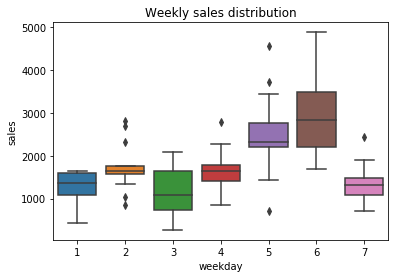

In [16]:
# plot below try to capture trend and distribution of sales through weeks, months and year

plot = sns.boxplot(x='weekday', y='sales', data=df)
_ = plot.set(title='Weekly sales distribution')

Inference:The Average amount of sales is almost random and is maximum on Saturday (6) and takes a sharp fall on Sunday (7)

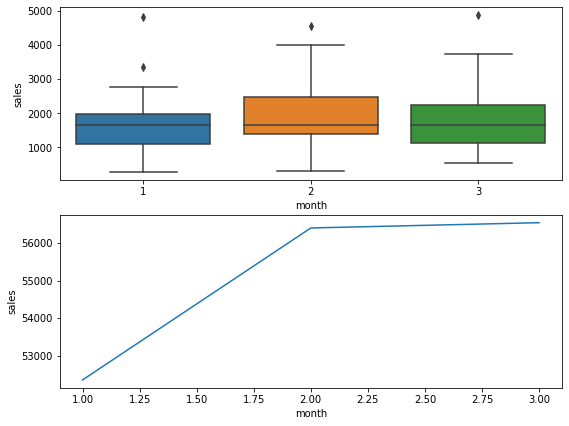

In [21]:
monthly_agg = df.groupby('month')['sales'].sum().reset_index()
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(9, 7))
sns.boxplot(x='month', y='sales', data=df, ax=ax[0])
_ = sns.lineplot(x='month', y='sales', data=monthly_agg, ax=ax[1])

Inference: The smallest sales was recorded in Junuary and highest sales was in February. We have sales between. we have more higher sales in february than in March it increases in february and drops in march

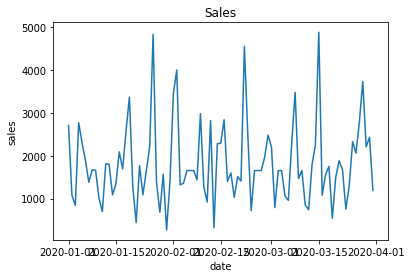

In [22]:
plot = sns.lineplot(x='date', y='sales', data=df)
_ = plot.set(title='Sales')

Inference: There exist a seasonal pattern in the number of sales. There seems to be a peak in sales every middle of the month and a downward trend could be observe at the end of every month

${\textbf{Quantitative Methods to Forecast Product Sales}}$

It can be fairly concluded from the data exploration plots above that there is seasonality present in the sales data, along with a general increase in the number of sales over the years. Therefore, in order to forecast the number of sales for the 1 week, we will keep in mind the linear trend and seasonality present in the product sales. ${\n}$ 
There are multiple ways to approach the forecasting problem, we can either build traditional time series models, or use causal models, like linear regression

#### Seasonal Naive: Baseline Model

Seasonal Naive is a method that takes the seasonal patterns into account by looking at what happened same time last month or year.

in the code below, one week is subtracted from the dates in test data, and the one day is added to the resulting difference, after which they are looked up in the training data to return the sales from those respective date.

In [27]:
# subtract 1 week from test data
dates = (test_df['date'] - np.timedelta64(1, 'W') + np.timedelta64(1, 'D')).values.astype('datetime64[D]')
seasonal_naive_sales = train_df[train_df['date'].astype('datetime64[D]').isin(dates)]['sales']

# make a copy of the test_df and make naive predictions for the last 1 week of march
sn_pred_df = test_df.copy().drop('sales', axis=1)
sn_pred_df['seasonal_naive_sales'] = pd.DataFrame(seasonal_naive_sales).set_index(test_df.drop(6,
                                                                                               axis=0).index)
sn_pred_df.head()

,date,year,month,day,weekday,seasonal_naive_sales
0,2020-03-25,2020,3,25,2,540.0
1,2020-03-26,2020,3,26,3,1495.0
2,2020-03-27,2020,3,27,4,1880.0
3,2020-03-28,2020,3,28,5,1680.0
4,2020-03-29,2020,3,29,6,755.0


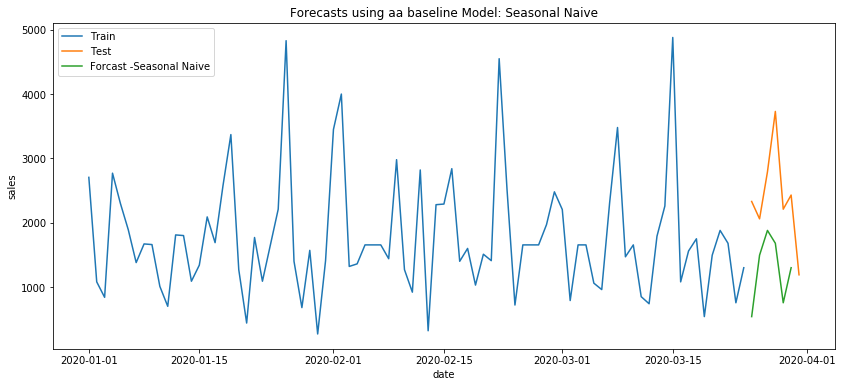

In [30]:
plt.figure(figsize=(14, 6))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(test_df['date'], test_df['sales'], label='Test')
plt.plot(sn_pred_df['date'], sn_pred_df['seasonal_naive_sales'], label='Forcast -Seasonal Naive')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using aa baseline Model: Seasonal Naive')
plt.show()

Inference: The model is not doing well walai

${\textbf{ Evaluating the Forecasts}}$

There are number of widely accepted forecasting metrics and the most common metrics is forecast error.
in order to evaluate the overall forecast, we will look at metrics like mean absolute error (MAE), root mean squared error (RMSE) and a percentage error metric mean absolute percentage error (MAPE)
<html>
    <ul>
        <li> MAE: It is absolute value of the error, summed for each observed day, and divided by the total number of observed days</li>
        <li> <b>RMSE:</b> It is similar to MAE, however rather than the absolute value, the error is squared before it is summed, and then the square root is taken to normalize the units. Because we take the square of the rror, we wind up punishing large forecasting errors more than small ones</li>
            <li>MAPE: it can be ised for meaningful comparisions, it is calculated by dividing the sum of absolute errors by sum of actual sales to get a percentage indicator that is scaled to the actual</li>
            </ul>
        </html>

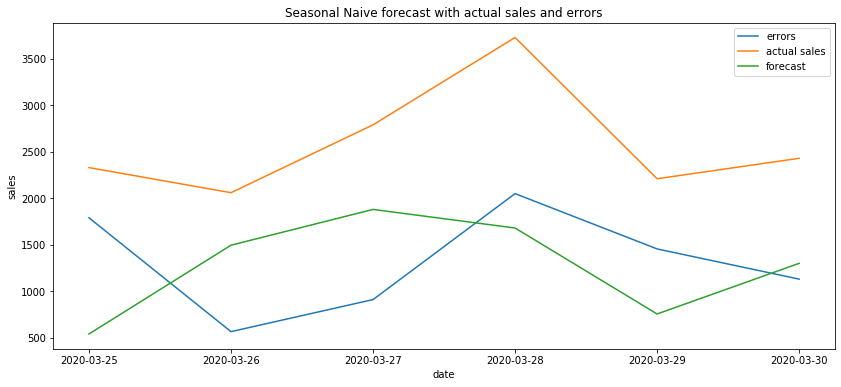

,total_sales,total_sn_pred_sales,overall_error,MAE,RMSE,MAPE
model,,,,,,
Seasonal Naive,15550.0,7650.0,7900.0,1316.666667,1411.137248,50.803859


In [33]:
errors_df = pd.merge(test_df.drop(6), sn_pred_df, on='date')
errors_df = errors_df[['date', 'sales', 'seasonal_naive_sales']]
errors_df['errors'] = test_df.drop(6)['sales'] - sn_pred_df['seasonal_naive_sales']
errors_df.insert(0, 'model', 'Seasonal Naive')

def mae(err):
    return np.mean(np.abs(err))
def rmse(err):
    return np.sqrt(np.mean(err ** 2))
def mape(err, sales=errors_df['sales']):
    return np.sum(np.abs(err)) / np.sum(sales) * 100

result_df = errors_df.groupby('model').agg(total_sales=('sales', 'sum'), total_sn_pred_sales =
                                           ('seasonal_naive_sales', 'sum'),
                                           overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse),
                                          MAPE=('errors', mape))

plt.figure(figsize=(14, 6))
plt.plot(errors_df['date'], np.abs(errors_df['errors']), label='errors')
plt.plot(errors_df['date'], errors_df['sales'], label='actual sales')
plt.plot(errors_df['date'], errors_df['seasonal_naive_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Seasonal Naive forecast with actual sales and errors')
plt.show()

result_df

${\textbf{Time Series Decomposition Plot}}$

A time series decomposition plot allows us to observe the seasonality, trend and error/ remainder terms of a time series. These three components are a crucial part of the Exponential Smoothing models. Therefore, the decomposiotn plot helps in deciding the hype of Exponential Smoothing Model to use for our forecastes

In [34]:
ts_decomp_df = train_df.set_index('date')
ts_decomp_df['sales'] = ts_decomp_df['sales'].astype(float)
ts_decomp_df.head()

,sales,year,month,day,weekday
date,,,,,
2020-01-01,2705.0,2020,1,1,2
2020-01-02,1080.0,2020,1,2,3
2020-01-03,840.0,2020,1,3,4
2020-01-04,2770.0,2020,1,4,5
2020-01-05,2300.0,2020,1,5,6


<Figure size 432x288 with 0 Axes>

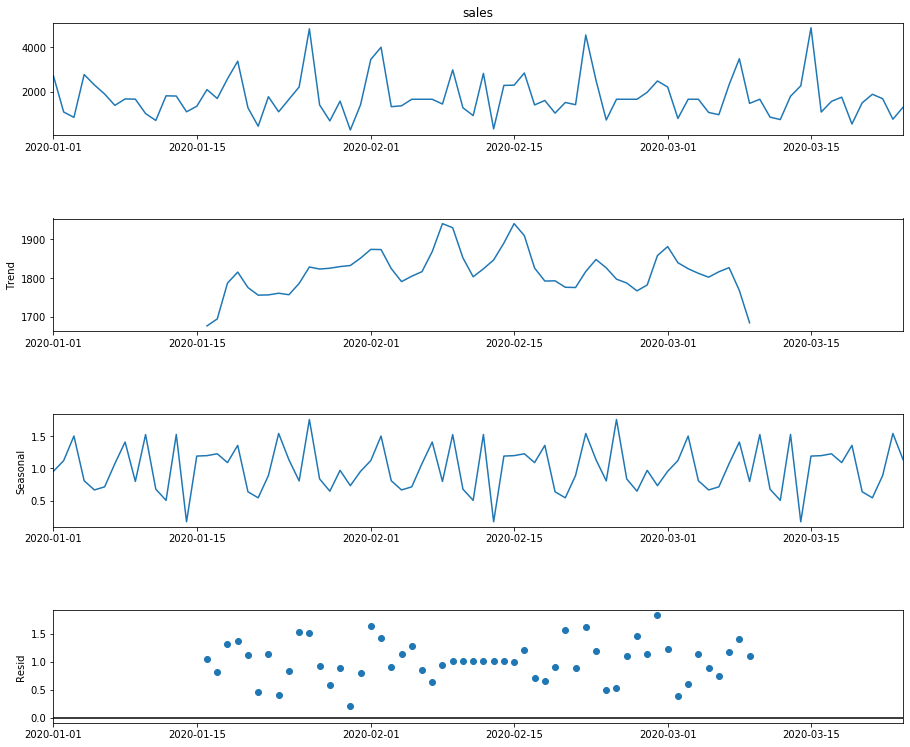

In [36]:
result = seasonal_decompose(ts_decomp_df['sales'], model='multiplicative', freq=30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(14, 12)

An ETS model has 3 main components: error, trend and seasonality. Each can be applied either additivelity, multiplicatively or not at all.
<ol>
    <li>Trend -  if the trend plot is linear then we apply it additively(A). if the trend line grows or shrinks exponentially, we apply it multiplicatively (M). if there is no clear trend, no trend component is included (N) </li>
    <li> Seasonal -  if the peaks and valleys for seasonality are constant over time, we apply it additively (A). if the size of the seasonal fluctuations tends to increase or decrease with the leel of time series, we apply it Multiplicatively (M). if there is no seasonality, it is not applied (N)</li>
        <li> Error -  if the error plot has constant variance over time (peaks and valleys are about the same size), we apply it additively (A). if the error plot is fluactuating between large and small errors over time we apply it multiplicatively (M)  </li>
    

### 2. Holt Winter's Triple Exponential Smoothing Model

In [41]:
hw_train_df = train_df[['date', 'sales']].set_index('date')
hw_test_df = test_df[['date', 'sales']].set_index('date')
# Apply Triple Exponential Smoothing

hw_model_1 = ExponentialSmoothing(hw_train_df, seasonal='add', seasonal_periods=3)
hw_fit_1 = hw_model_1.fit(use_boxcox=False, remove_bias=False)
pred_fit_1 = pd.Series(hw_fit_1.predict(start=hw_test_df.index[0], end=hw_test_df.index[-1]),
                       name='pred_sales').reset_index()

hw_model_2 = ExponentialSmoothing(hw_train_df,  seasonal='add', seasonal_periods=3, damped=False)
hw_fit_2 = hw_model_2.fit(use_boxcox=False, remove_bias=False)
pred_fit_2 = pd.Series(hw_fit_2.predict(start=hw_test_df.index[0], end=hw_test_df.index[-1]),
                       name='pred_sales').reset_index()

print('Forecastes made, ready for evaluation')

Forecastes made, ready for evaluation


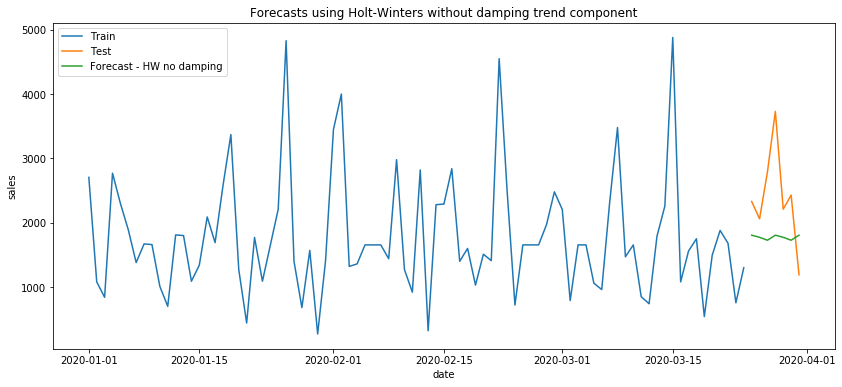

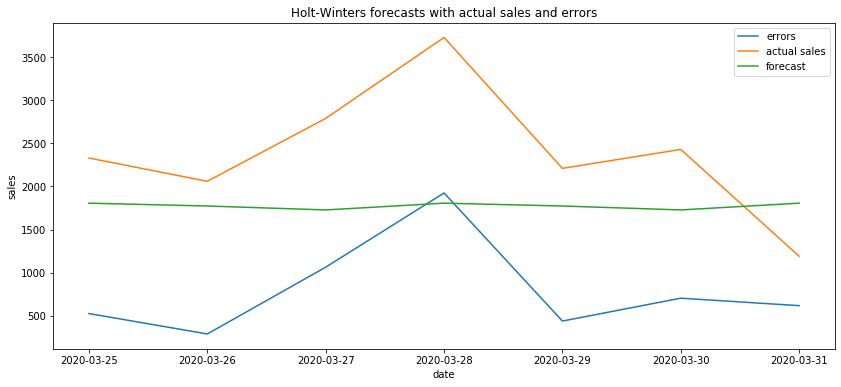

,total_sales,total_pred_sales,holt_winters_overall_error,MAE,RMSE,MAPE
model,,,,,,
Holt-Winters,16740.0,12418.27738,4321.72262,793.347866,945.100695,35.713409


In [42]:
# merge predictions and actual sales into one df

errors_df_hw = pd.merge(test_df, pred_fit_1, left_on='date', right_on='index')
errors_df_hw = errors_df_hw[['date', 'sales', 'pred_sales']]
errors_df_hw['errors'] = errors_df_hw.sales - errors_df_hw.pred_sales

errors_df_hw.insert(0, 'model', 'Holt-Winters')

# Evaluate the predictions for Holt-Winters without damping trend component
plt.figure(figsize=(14,6))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(test_df['date'], test_df['sales'], label='Test')
plt.plot(errors_df_hw['date'], errors_df_hw['pred_sales'], label='Forecast - HW no damping')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Holt-Winters without damping trend component')
plt.show()

plt.figure(figsize=(14,6))
plt.plot(errors_df_hw['date'], np.abs(errors_df_hw['errors']), label='errors')
plt.plot(errors_df_hw['date'], errors_df_hw['sales'], label='actual sales')
plt.plot(errors_df_hw['date'], errors_df_hw['pred_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Holt-Winters forecasts with actual sales and errors')
plt.show()

result_df_hw = errors_df_hw.groupby('model').agg(total_sales=('sales', 'sum'),
                                                total_pred_sales=('pred_sales', 'sum'),
                                                holt_winters_overall_error=('errors', 'sum'),
                                                MAE=('errors', mae),
                                                RMSE=('errors', rmse),
                                                MAPE=('errors', mape))

result_df_hw

The MAPE is a bit better now but there is still more to be done

${\textbf{Autoregressive Integrated Moving Average - ARIMA Model}}$

Step 1: Check Stationarity
Before going any further into our analysis, our series has to be made stationary.<br>
Stationarity is the property of exhibiting constant statistical properties (mean, variance, autocorrelation etc). if the mean of a tm increases over time, then it not stationary. <br>

The mean across many time periods is only informative if the expected value is the same across time periods. If these population parameters can vary, what are we really estimating by taking an average across time? <br>

Stationarity requires that the statistical properties must be the same across time, making the sample average a reasonable way to estimate them.
<br>
Methods to Check Stationarity <br>
 `1` Plotting rolling statistics: plotting rolling mean and variance is a first good way to visually inspect our series. If the rolling statistics exhibit a clear trend (upwards or downwards) and show varying variance (increasing or decreasing amplitude), then you might conclude that the series is very likely not stationary. <br>
 <br>
 `2` ACF and PACF plots: An autocorrelation plot (ACF) represent the autocorrelation of the series with lags of itself. A partialACF plot represent the amount of correlation beetween a series and a lag of itself that is not explained by correlations at all lower-order lags Ideally, we want no corralation between the series and lags of itself.
 Graphically speaking, we would like all the spikes to fall in the blue region.

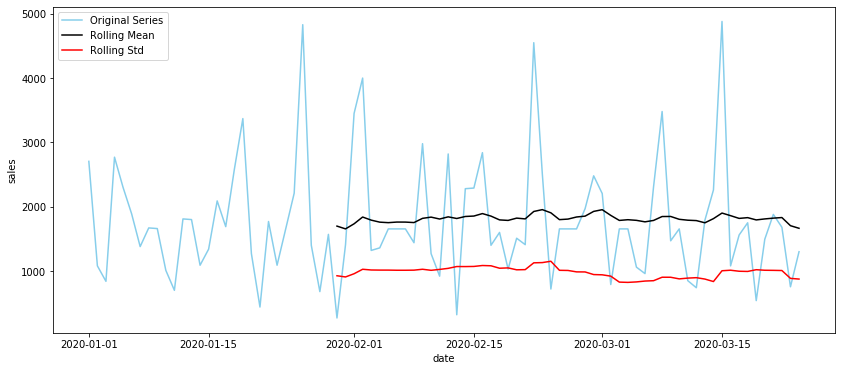

Test Statistics = -3.558
P-value = 0.007
Critical values :
	1%: -3.520713130074074 - The data is  stationary with 99% confidence
	5%: -2.9009249540740742 - The data is  stationary with 95% confidence
	10%: -2.5877813777777776 - The data is  stationary with 90% confidence


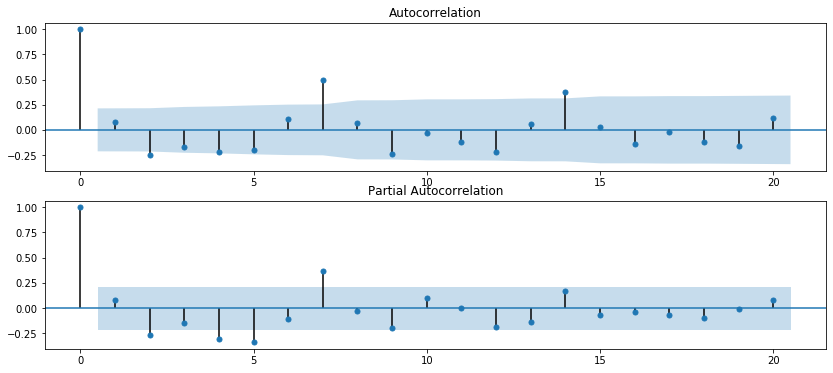

In [66]:
arima_df = train_df[['date', 'sales']].set_index('date')
arima_test_df = test_df[['date', 'sales']].set_index('date')

def test_stationarity(tm):
    # plotting rolling statistics
    rollmean = tm.rolling(window=30).mean()
    rollstd = tm.rolling(window=30).std()
    
    plt.figure(figsize=(14, 6))
    plt.plot(tm, color='skyblue', label='Original Series')
    plt.plot(rollmean, color='black', label='Rolling Mean')
    plt.plot(rollstd, color='red', label='Rolling Std')    
    plt.legend(loc='best')
    plt.xlabel('date')
    plt.ylabel('sales')
    plt.show()
    
    # Augmented Dickey-Fuller Test
    adfuller_test = adfuller(tm, autolag='AIC')
    print('Test Statistics = {:.3f}'.format(adfuller_test[0]))
    print('P-value = {:.3f}'.format(adfuller_test[1]))
    print('Critical values :')
    for key, value in adfuller_test[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(key, value,
                                                                               '' if adfuller_test[0] < value else 'not', 100 - int(key[:-1])))    
    fig, ax = plt.subplots(2, figsize=(14,6))
    ax[0] = plot_acf(tm, ax=ax[0], lags=20)
    ax[1] = plot_pacf(tm, ax=ax[1], lags=20)
    
test_stationarity(arima_df.sales)

Looking at this we can say that the data is stationary. Therefore we dont have to apply Differencing.
Differencing : Seasonal or cyclical patterns can be removed by subtracting periodical values. If the data is 12-month seasonal, subtracting the series with a 12 lag diffrence series will give a flatter series.

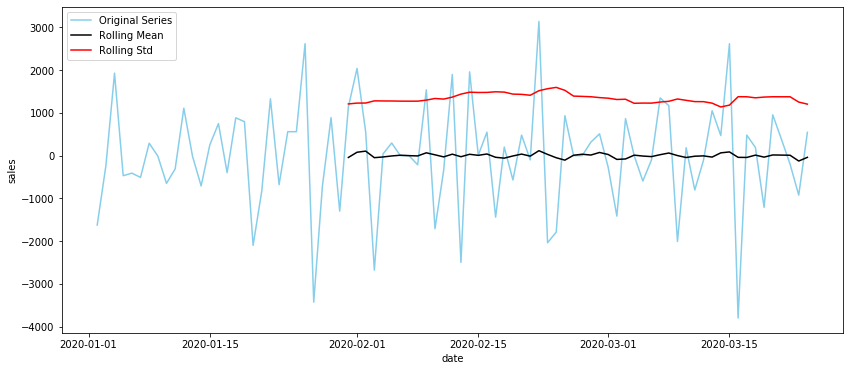

Test Statistics = -5.613
P-value = 0.000
Critical values :
	1%: -3.5219803175527606 - The data is  stationary with 99% confidence
	5%: -2.9014701097664504 - The data is  stationary with 95% confidence
	10%: -2.58807215485756 - The data is  stationary with 90% confidence


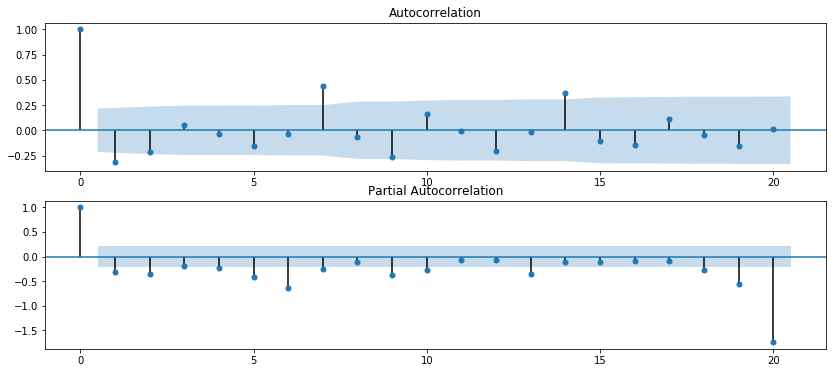

In [67]:
first_difference = arima_df.sales - arima_df.sales.shift(1)
first_difference = pd.DataFrame(first_difference.dropna(inplace=False))

test_stationarity(first_difference.sales)

#### Model Building

#### Interpreting  the AR(p), i(d), MA(q) values:

Determining I(d): Taking the first order difference makes the time series stationary. Therefore, I(d) = 1.
<br>
1. Determining AR(p): If the lag-1 autocorrelation of the differenced series PACF is negative, and / or there is a sharp cutoff, then choose a AR order of 1. <br>

From the PACF plot we can clearly observe that within 2 lags the AR is significant. Therefore, we can use AR(p) = 2, (2 lines are crossed the blue lines so 2 past days are required to predict
<br>

2. Determining MA(q): if the lag 1 autocorrelation of the differenced of the series ACF is negative and or there is a sharp cutoff, then choose a MA order of 1. <br>

From the ACF plot we see a negative spike at lag 1, therefore we can use MA(q) = 1

In [61]:
arima_model_8_1 = ARIMA(arima_df.sales, (2,1,1)).fit(disp=False)

print(arima_model_8_1.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                   83
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -684.707
Method:                       css-mle   S.D. of innovations            899.189
Date:                Tue, 14 Apr 2020   AIC                           1379.414
Time:                        19:43:51   BIC                           1391.508
Sample:                    01-02-2020   HQIC                          1384.273
                         - 03-24-2020                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.6546      3.591     -0.182      0.855      -7.692       6.383
ar.L1.D.sales     0.1097      0.107      1.028      0.304      -0.100       0.319
ar.L2.D.sales    -0.2514      0.107     

Since we identify seasonality in our series we should use the SARIMAX Seasonal ARIMA

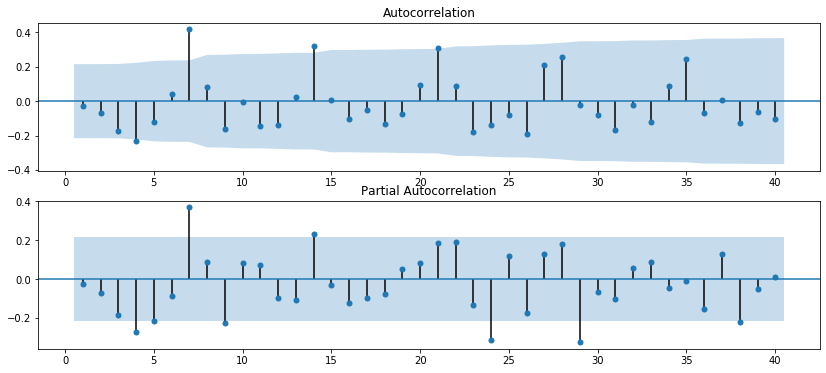

In [63]:
residuals = arima_model_8_1.resid

# check for seasonality
fig, ax = plt.subplots(2, figsize=(14,6))
ax[0] = plot_acf(residuals, ax=ax[0], lags=40, zero=False)
ax[1] = plot_pacf(residuals, ax=ax[1], lags=40, zero=False)

# The below plots are similar hence seasonality

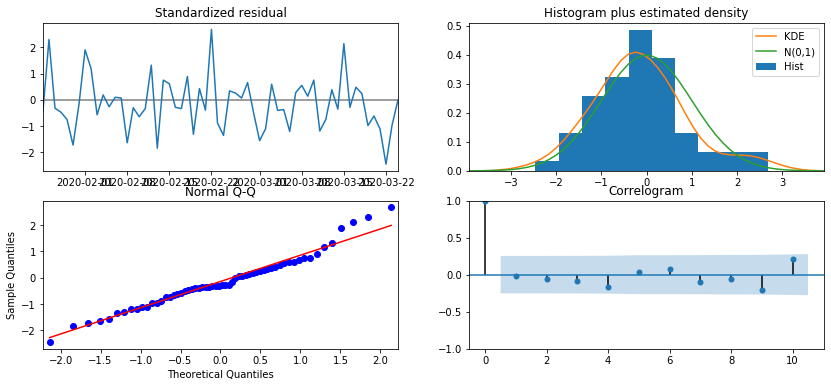

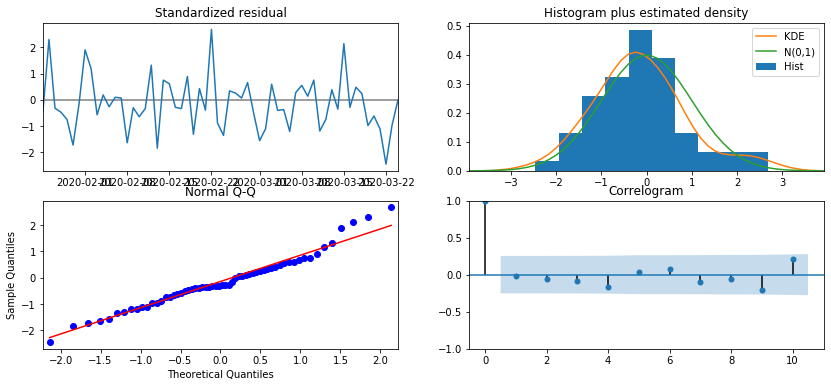

In [74]:
sarima_model = SARIMAX(arima_df.sales, order=(2,1,1), seasonal_order=(2,1,1, 7),
                       enforce_invertibility=False, enforce_stationarity=False)
sarima_fit = sarima_model.fit()
arima_test_df['pred_sales'] = sarima_fit.predict(start=arima_test_df.index[0],
                                                 end=arima_test_df.index[-1], dynamic=True)
plot = sarima_fit.plot_diagnostics(figsize=(14,6))
plot

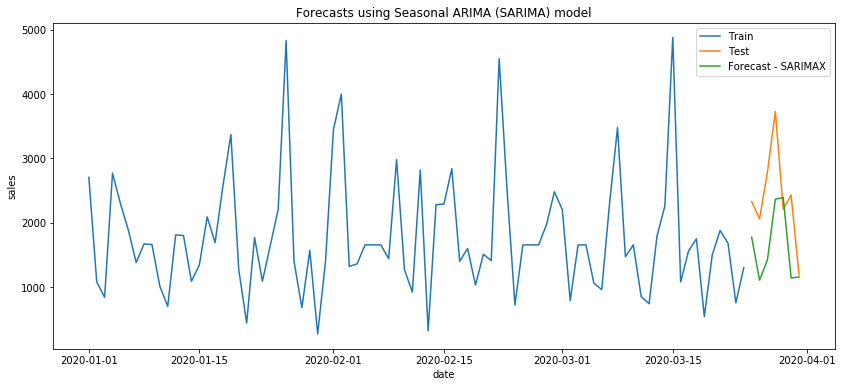

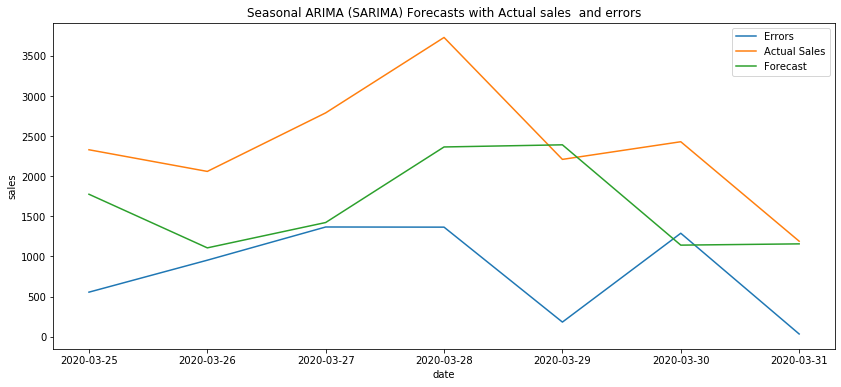

,total_sales,total_pred_sales,SARIMA_overall_error,MAE,RMSE,MAPE
model,,,,,,
SARIMA,16740.0,11359.009872,5380.990128,820.585555,974.294803,36.939543


In [76]:
arima_test_df['errors'] = arima_test_df.sales - arima_test_df.pred_sales
# arima_test_df.insert(0, 'model', 'SARIMA')

plt.figure(figsize=(14,6))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(arima_test_df.index, arima_test_df['sales'], label='Test')
plt.plot(arima_test_df.index, arima_test_df['pred_sales'], label='Forecast - SARIMAX')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Seasonal ARIMA (SARIMA) model')
plt.show()

plt.figure(figsize=(14,6))
plt.plot(arima_test_df.index, np.abs(arima_test_df['errors']), label='Errors')
plt.plot(arima_test_df.index, arima_test_df['sales'], label='Actual Sales')
plt.plot(arima_test_df.index, np.abs(arima_test_df['pred_sales']), label='Forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Seasonal ARIMA (SARIMA) Forecasts with Actual sales  and errors')
plt.show()

result_df_sarima = arima_test_df.groupby('model').agg(total_sales=('sales', 'sum'),
                                                total_pred_sales=('pred_sales', 'sum'),
                                                SARIMA_overall_error=('errors', 'sum'),
                                                MAE=('errors', mae),
                                                RMSE=('errors', rmse),
                                                MAPE=('errors', mape))

result_df_sarima

<b>Inference</b> The SARIMA model with MAPE of 37% performed better than our baseline model, but could not better the Hotl-Winter Exponential Smoothing method

Let try the Linear Regression Model and evaluate

In [84]:
# Linear Regression

lr_df = df
lr_df

,date,sales,year,month,day,weekday,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean,rolling_max,rolling_min
0,2020-01-01,2705.0,2020,1,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-02,1080.0,2020,1,2,3,2705.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-03,840.0,2020,1,3,4,1080.0,2705.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-04,2770.0,2020,1,4,5,840.0,1080.0,2705.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-05,2300.0,2020,1,5,6,2770.0,840.0,1080.0,2705.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,2020-03-27,2790.0,2020,3,27,4,2060.0,2330.0,1300.0,755.0,1680.0,1880.0,1495.0,1827.857143,2790.0,755.0
87,2020-03-28,3730.0,2020,3,28,5,2790.0,2060.0,2330.0,1300.0,755.0,1680.0,1880.0,2092.142857,3730.0,755.0
88,2020-03-29,2210.0,2020,3,29,6,3730.0,2790.0,2060.0,2330.0,1300.0,755.0,1680.0,2167.857143,3730.0,755.0
89,2020-03-30,2430.0,2020,3,30,7,2210.0,3730.0,2790.0,2060.0,2330.0,1300.0,755.0,2407.142857,3730.0,1300.0


In [85]:
# Lag Features
for i in range(1, 8):
    lag_i = 'lag_' + str(i)
    lr_df[lag_i] = lr_df.sales.shift(i)
    
# Rolling window
lr_df['rolling_mean'] = lr_df.sales.rolling(window=7).mean()
lr_df['rolling_max'] = lr_df.sales.rolling(window=7).max()
lr_df['rolling_min'] = lr_df.sales.rolling(window=7).min()

lr_df = lr_df.dropna(how='any')
# split the series for training and Testing
lr_df = lr_df.set_index('date')
lr_train_df = lr_df.loc[:'2020-03-24']
lr_test_df = lr_df.loc['2020-03-25':]

### Feature Selection and Model Building

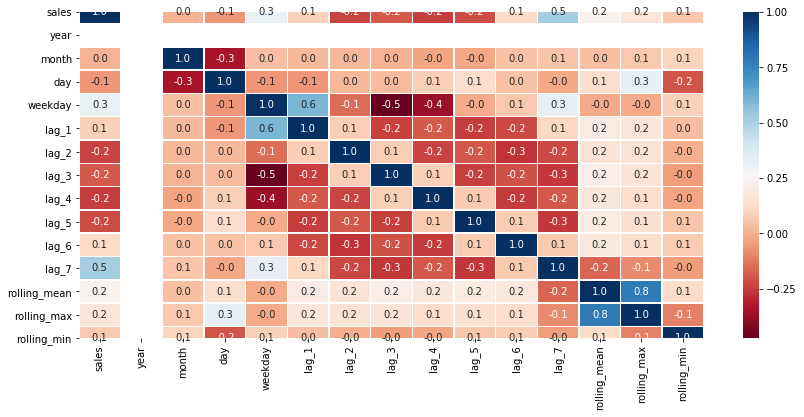

In [86]:
# Correlation Matrix with heatmap
corr = lr_train_df.corr()
fig = plt.figure(figsize=(14, 6))
_ = sns.heatmap(corr, linewidths=.5, annot=True, fmt='.1f', cmap='RdBu')

In [87]:
X_train = lr_train_df.drop(['year', 'sales'], axis=1)
y_train = lr_train_df['sales'].values

X_test = lr_test_df.drop(['year', 'sales'], axis=1)
y_test = lr_test_df['sales'].values


# Univariate SelectKBest class to extract top 5 best features
top_features = SelectKBest(score_func=f_regression, k=5)
fit = top_features.fit(X_train, y_train)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X_train.columns)

# concat 2 dataframe for better visualization
feature_scores = pd.concat([df_columns, df_scores], axis=1)
feature_scores.columns = ['Feature', 'Score']
print(feature_scores.nlargest(5, 'Score'))

         Feature      Score
9          lag_7  27.196139
2        weekday   8.023940
6          lag_4   4.876109
10  rolling_mean   4.469363
4          lag_2   4.329181


[Text(0.5, 1.0, 'Linear relationship between sales and rolling_mean')]

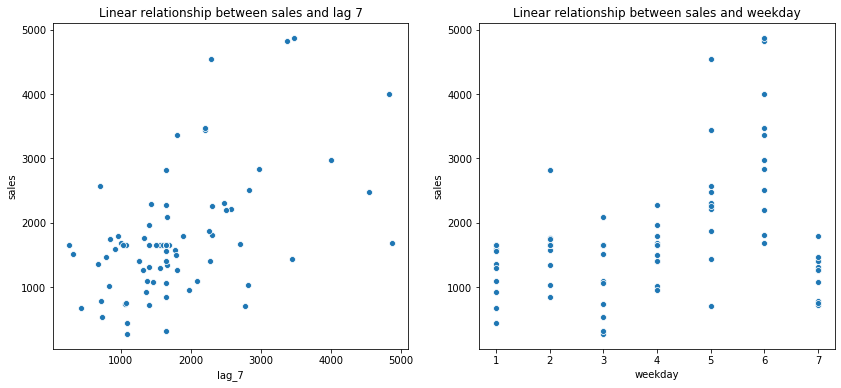

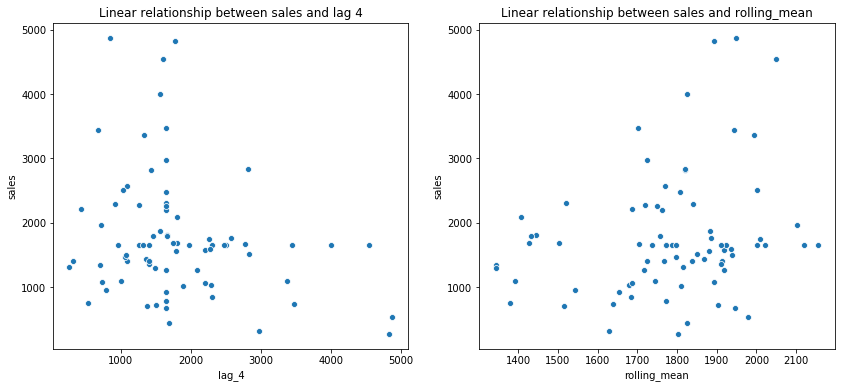

In [88]:
# Checking for a linear relationship of the top features with sales (target variable)

fig, ax = plt.subplots(ncols=2, figsize=(14, 6))
sns.scatterplot(lr_train_df.lag_7, lr_train_df.sales, ax=ax[0])
ax[0].set(title='Linear relationship between sales and lag 7')

sns.scatterplot(lr_train_df.weekday, lr_train_df.sales, ax=ax[1])
ax[1].set(title='Linear relationship between sales and weekday')

fig, ax = plt.subplots(ncols=2, figsize=(14, 6))
sns.scatterplot(lr_train_df.lag_4, lr_train_df.sales, ax=ax[0])
ax[0].set(title='Linear relationship between sales and lag 4')

sns.scatterplot(lr_train_df.rolling_mean, lr_train_df.sales, ax=ax[1])
ax[1].set(title='Linear relationship between sales and rolling_mean')

The linear relationship is not really clear but we could observe linear relationship on lag_7 though the rest is not obvious so linear relationship might not be the best model to forecast sales here but we could still try and evaluate the model. Right? Also this might be as a result of the data size. so say the data is much then the linear relationship might be very visible

In [91]:
# Update X_train, X_test to include top features
X_train = X_train[['rolling_mean', 'lag_7', 'lag_4', 'weekday', 'lag_2']]
X_test = X_test[['rolling_mean', 'lag_7', 'lag_4', 'weekday', 'lag_2']]

# fit model
model = LinearRegression()
model.fit(X_train, y_train)

preds = model.predict(X_test)
errors_df = lr_test_df[['sales']]
errors_df['pred_sales'] = preds
errors_df['errors'] = y_test - preds
errors_df.insert(0, 'model', 'LinearRegression')

#### Model Evaluation and Prediction

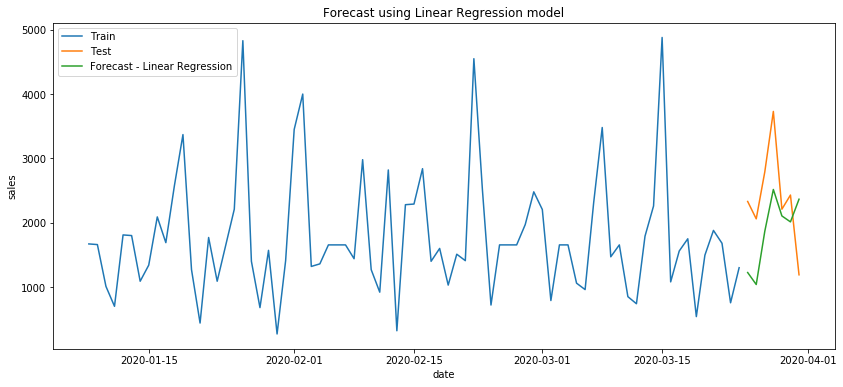

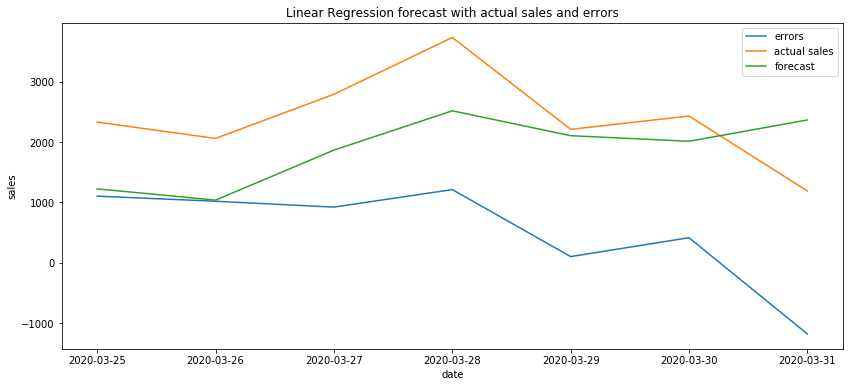

,total_sales,total_pred_sales,LR_overall_error,MAE,RMSE,MAPE
model,,,,,,
LinearRegression,16740.0,13130.397223,3609.602777,851.407685,937.620129,38.327034


In [92]:
#eval predictions
fig = plt.figure(figsize=(14, 6))
plt.plot(lr_train_df.index, lr_train_df['sales'], label='Train')
plt.plot(lr_test_df.index, lr_test_df['sales'], label='Test')
plt.plot(errors_df.index, errors_df['pred_sales'], label='Forecast - Linear Regression')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecast using Linear Regression model')
plt.show()

fig = plt.figure(figsize=(14, 6))
plt.plot(errors_df.index, errors_df.errors, label='errors')
plt.plot(errors_df.index, errors_df.sales, label='actual sales')
plt.plot(errors_df.index, errors_df.pred_sales, label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Linear Regression forecast with actual sales and errors')
plt.show()

result_df_lr = errors_df.groupby('model').agg(total_sales=('sales', 'sum'),
                                             total_pred_sales = ('pred_sales', 'sum'),
                                             LR_overall_error=('errors', 'sum'),
                                             MAE=('errors', mae),
                                             RMSE=('errors', rmse),
                                             MAPE=('errors', mape))
result_df_lr

we considered diffrent time-series models as well as a regression model for time series forecasting. From our result the holt-winter smoothing model performed better than other models.
so we could use the model to forecast sales and get a decent score. Although the model could be improved by providing more data and further fine tuning the model. I hop tou have learn something new

creadit to akshitvjain for His Notebook on Time Series, I used it and modelled it on a new data that i generate myself from my Mothers store so i probably will update the model once i have more data.
Thank you all you can leave a star as you learn. cheers